<a href="https://www.kaggle.com/code/ritvik1909/object-detection-selective-search" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Object Detection using Selective Search

We will be using concepts of Selective Search and Non-Maxima Supression to turn almost any Image Classifier into an Object Detector
* **Selective Search**: 
  * Selective Search algorithm over-segments an image via:
    * Color similarity: Computing a 25-bin histogram for each channel of an image, concatenating them together, and obtaining a final descriptor that is 25×3=75-d. Color similarity of any two regions is measured by the histogram intersection distance.
    * Texture similarity: For texture, Selective Search extracts Gaussian derivatives at 8 orientations per channel (assuming a 3-channel image). These orientations are used to compute a 10-bin histogram per channel, generating a final texture descriptor that is 8x10x=240-d. To compute texture similarity between any two regions, histogram intersection is once again used.
    * Size similarity: The size similarity metric that Selective Search uses prefers that smaller regions be grouped earlier rather than later. By enforcing smaller regions to merge earlier, we can help prevent a large number of clusters from swallowing up all smaller regions.
    * Shape similarity: The idea behind shape similarity in Selective Search is that they should be compatible with each other. Two regions are considered “compatible” if they “fit” into each other (thereby filling gaps in our regional proposal generation). Furthermore, shapes that do not touch should not be merged.
    * A final meta-similarity measure: A final meta-similarity acts as a linear combination of the color similarity, texture similarity, size similarity, and shape similarity/compatibility.
* **Non-Maxima Supression**:
  * When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.
  * We somehow need to collapse/remove the extraneous bounding boxes.
  * Non-maxima suppression (NMS) collapses weak, overlapping bounding boxes in favor of the more confident ones.
  
**Credits**: [PyImageSearch](https://pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/)

In [1]:
%%capture
!pip install imutils huggingface_hub

In [2]:
import numpy as np
import argparse
import imutils
import time
import cv2

import tensorflow as tf
from huggingface_hub import from_pretrained_keras

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt

11501568/11490434 [==============================] - 0s 0us/step


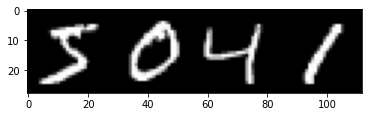

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

orig = np.zeros((28, 112))
orig[:, :28] = x_train[0]
orig[:, 28:56] = x_train[1]
orig[:, 56:84] = x_train[2]
orig[:, 84:] = x_train[3]
(H, W) = orig.shape[:2]
plt.imshow(orig, cmap='gray');

In [4]:
class SelectiveSearchObjectDetection():
    def __init__(self, pretrained_classifier_path, **kwargs):
        self.model = from_pretrained_keras(pretrained_classifier_path)
        self.kwargs = kwargs
        
    def selective_search(self, image, method="fast"):
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        if method == "fast":
            ss.switchToSelectiveSearchFast()
        else:
            ss.switchToSelectiveSearchQuality()
        return ss.process()
    
    def get_rois_and_locs(self, rects):
        rois = []
        locs = []
        for (x, y, w, h) in rects:
            if w / float(W) < 0.1 or h / float(H) < 0.1:
                continue
            roi = orig[y:y + h, x:x + w]
            roi = cv2.resize(roi, self.kwargs['INPUT_SIZE'])
            rois.append(roi)
            locs.append((x, y, w, h))
        return rois, locs
    
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')
            
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.model.predict(rois)
        preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        labels = {}

        for (i, p) in enumerate(preds):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def apply_nms(self, labels):
        nms_labels = {}
        for label in sorted(labels.keys()):
            boxes = np.array([p[0] for p in labels[label]])
            proba = np.array([p[1] for p in labels[label]])
            boxes = non_max_suppression(boxes, proba)
            nms_labels[label] = boxes.tolist()
        return nms_labels
            
    def visualize_preds(self, img, nms_labels):
        for label in sorted(nms_labels.keys()):
            clone = img.copy()
            fig, ax = plt.subplots(figsize=(20, 6))
            boxes = nms_labels[label]
            for (startX, startY, width, height) in boxes:
                cv2.rectangle(clone, (startX, startY), (startX+width, startY+height), (255, 255, 255), 1)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)

            ax.imshow(clone, cmap='gray')
            ax.set_title("After")
    
    def __call__(self, img):
        rects = self.selective_search(np.dstack([img, img, img]).astype(np.float32))
        rois, locs = self.get_rois_and_locs(rects)
        if self.kwargs['VIZ_ROIS']:
            self.visualize_rois(rois)
        preds, labels = self.get_preds(rois, locs)
        nms_labels = self.apply_nms(labels)
        
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        return nms_labels

In [5]:
kwargs = dict(INPUT_SIZE=(28, 28), MIN_CONF=0.9, VISUALIZE=True, VIZ_ROIS=True)

config.json not found in HuggingFace Hub


Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/373 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/530k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/38.2k [00:00<?, ?B/s]

Predictions:  {0: [[32, 2, 21, 24], [34, 3, 18, 22], [33, 3, 19, 22], [34, 4, 17, 20], [35, 5, 16, 18], [35, 4, 16, 19]], 1: [[90, 3, 18, 24], [91, 4, 16, 22]], 4: [[57, 3, 24, 24], [0, 0, 112, 28], [59, 5, 20, 20], [59, 5, 19, 21]], 5: [[3, 4, 22, 22]]}


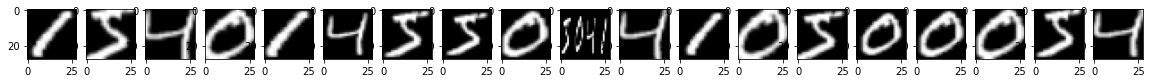

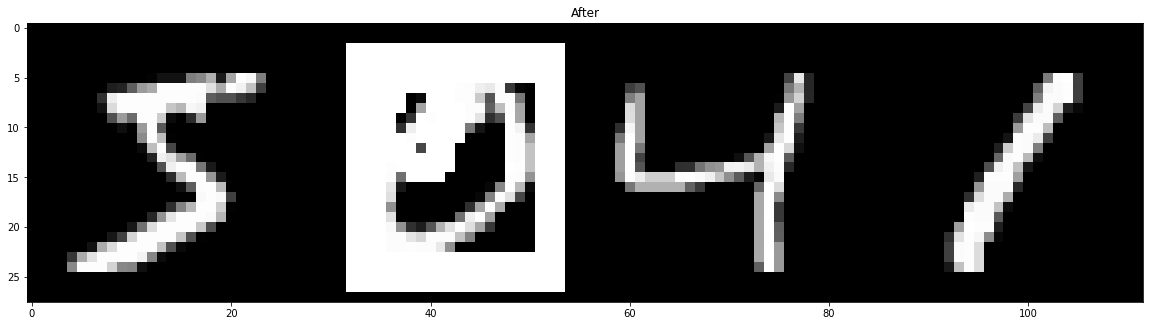

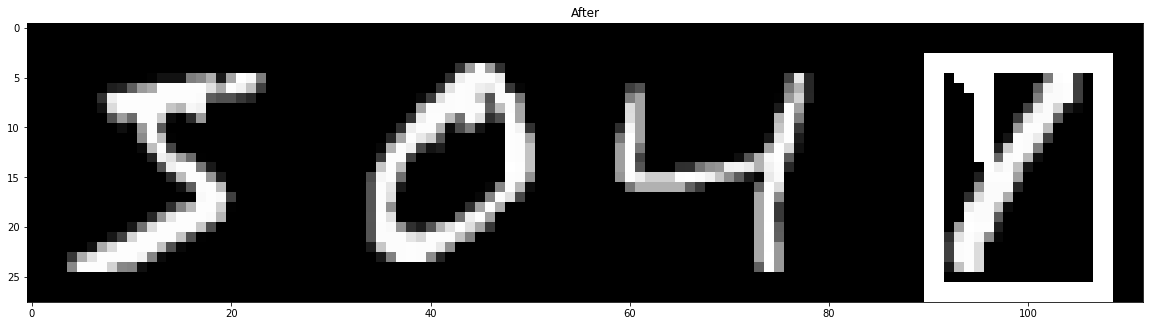

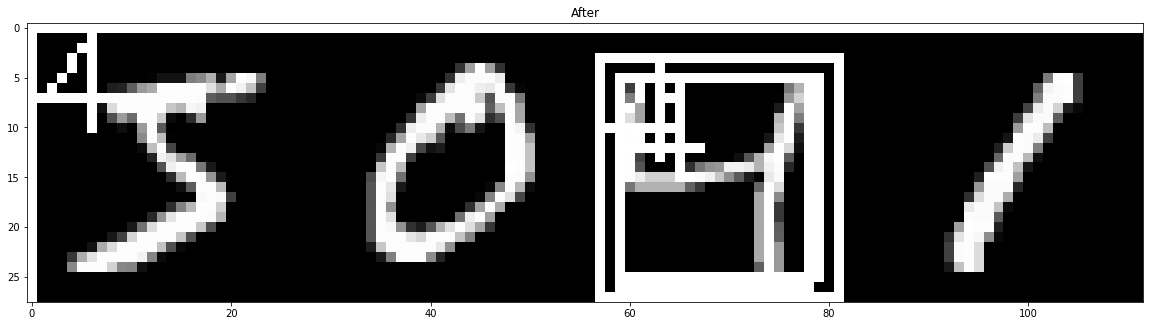

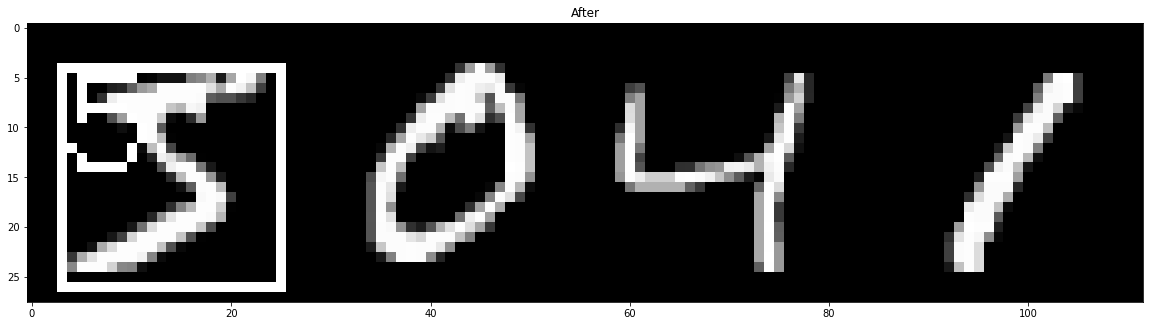

In [6]:
# Ritvik19/mnist-net is a convnet trained on mnist data read more: https://huggingface.co/Ritvik19/mnist-net
model = SelectiveSearchObjectDetection('Ritvik19/mnist-net', **kwargs)
preds = model(orig)
print("Predictions: ", preds)

# Ending Notes
* The above approach simplifies what happens in an RCNN
* We can build a Fast RCNN using the same approach, with few additional steps:
  * Data Preparation:
      * Use selective search to detect objects in your image dataset
      * Label those images with appropriate classes and Bounding boxes
  * Modelling:
      * Use a pretrained CNN to extract feature maps from the input image
      * Use selective search to identify ROIs in the input image
      * Use ROI Pooling to project the ROIs into the feature maps
      * Train a downstream classifier to classify the images, and a bounding box regression model